<a href="https://colab.research.google.com/github/nidaa-hub/HaifaUniv_AI_Lab_2022/blob/main/AI_2022_Lab_4_B.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Lab 4 part II

*   ID Submetter1: 316151232
*   ID Submetter2: 038163630

Please Run by order to create the files.

Press ▶ or ctrl+Enter

In [50]:
%%writefile Iocaine.py 

import random


def recall(age, hist):
    """Looking at the last 'age' points in 'hist', finds the
    last point with the longest similarity to the current point,
    returning 0 if none found."""
    end, length = 0, 0
    for past in range(1, min(age + 1, len(hist) - 1)):
        if length >= len(hist) - past: break
        for i in range(-1 - length, 0):
            if hist[i - past] != hist[i]: break
        else:
            for length in range(length + 1, len(hist) - past):
                if hist[-past - length - 1] != hist[-length - 1]: break
            else: length += 1
            end = len(hist) - past
    return end

def beat(i):
    return (i + 1) % 3
def loseto(i):
    return (i - 1) % 3

class Stats:
    """Maintains three running counts and returns the highest count based
         on any given time horizon and threshold."""
    def __init__(self):
        self.sum = [[0, 0, 0]]
    def add(self, move, score):
        self.sum[-1][move] += score
    def advance(self):
        self.sum.append(self.sum[-1])
    def max(self, age, default, score):
        if age >= len(self.sum): diff = self.sum[-1]
        else: diff = [self.sum[-1][i] - self.sum[-1 - age][i] for i in range(3)]
        m = max(diff)
        if m > score: return diff.index(m), m
        return default, score

class Predictor:
    """The basic iocaine second- and triple-guesser.    Maintains stats on the
         past benefits of trusting or second- or triple-guessing a given strategy,
         and returns the prediction of that strategy (or the second- or triple-
         guess) if past stats are deviating from zero farther than the supplied
         "best" guess so far."""
    def __init__(self):
        self.stats = Stats()
        self.lastguess = -1
    def addguess(self, lastmove, guess):
        if lastmove != -1:
            diff = (lastmove - self.prediction) % 3
            self.stats.add(beat(diff), 1)
            self.stats.add(loseto(diff), -1)
            self.stats.advance()
        self.prediction = guess
    def bestguess(self, age, best):
        bestdiff = self.stats.max(age, (best[0] - self.prediction) % 3, best[1])
        return (bestdiff[0] + self.prediction) % 3, bestdiff[1]

ages = [1000, 100, 10, 5, 2, 1]

class Iocaine:

    def __init__(self):
        """Build second-guessers for 50 strategies: 36 history-based strategies,
             12 simple frequency-based strategies, the constant-move strategy, and
             the basic random-number-generator strategy.    Also build 6 meta second
             guessers to evaluate 6 different time horizons on which to score
             the 50 strategies' second-guesses."""
        self.predictors = []
        self.predict_history = self.predictor((len(ages), 2, 3))
        self.predict_frequency = self.predictor((len(ages), 2))
        self.predict_fixed = self.predictor()
        self.predict_random = self.predictor()
        self.predict_meta = [Predictor() for a in range(len(ages))]
        self.stats = [Stats() for i in range(2)]
        self.histories = [[], [], []]

    def predictor(self, dims=None):
        """Returns a nested array of predictor objects, of the given dimensions."""
        if dims: return [self.predictor(dims[1:]) for i in range(dims[0])]
        self.predictors.append(Predictor())
        return self.predictors[-1]

    def move(self, them):
        """The main iocaine "move" function."""

        # histories[0] stores our moves (last one already previously decided);
        # histories[1] stores their moves (last one just now being supplied to us);
        # histories[2] stores pairs of our and their last moves.
        # stats[0] and stats[1] are running counters our recent moves and theirs.
        if them != -1:
            self.histories[1].append(them)
            self.histories[2].append((self.histories[0][-1], them))
            for watch in range(2):
                self.stats[watch].add(self.histories[watch][-1], 1)

        # Execute the basic RNG strategy and the fixed-move strategy.
        rand = random.randrange(3)
        self.predict_random.addguess(them, rand)
        self.predict_fixed.addguess(them, 0)

        # Execute the history and frequency stratgies.
        for a, age in enumerate(ages):
            # For each time window, there are three ways to recall a similar time:
            # (0) by history of my moves; (1) their moves; or (2) pairs of moves.
            # Set "best" to these three timeframes (zero if no matching time).
            best = [recall(age, hist) for hist in self.histories]
            for mimic in range(2):
                # For each similar historical moment, there are two ways to anticipate
                # the future: by mimicing what their move was; or mimicing what my
                # move was.    If there were no similar moments, just move randomly.
                for watch, when in enumerate(best):
                    if not when: move = rand
                    else: move = self.histories[mimic][when]
                    self.predict_history[a][mimic][watch].addguess(them, move)
                # Also we can anticipate the future by expecting it to be the same
                # as the most frequent past (either counting their moves or my moves).
                mostfreq, score = self.stats[mimic].max(age, rand, -1)
                self.predict_frequency[a][mimic].addguess(them, mostfreq)

        # All the predictors have been updated, but we have not yet scored them
        # and chosen a winner for this round.    There are several timeframes
        # on which we can score second-guessing, and we don't know timeframe will
        # do best.    So score all 50 predictors on all 6 timeframes, and record
        # the best 6 predictions in meta predictors, one for each timeframe.
        for meta, age in enumerate(ages):
            best = (-1, -1)
            for predictor in self.predictors:
                best = predictor.bestguess(age, best)
            self.predict_meta[meta].addguess(them, best[0])

        # Finally choose the best meta prediction from the final six, scoring
        # these against each other on the whole-game timeframe. 
        best = (-1, -1)
        for meta in range(len(ages)):
            best = self.predict_meta[meta].bestguess(len(self.histories[0]) , best) 

        # We've picked a next move.    Record our move in histories[0] for next time.
        self.histories[0].append(best[0])

        # And return it.
        return best[0]

iocaine = None

def iocaine_agent(observation, configuration):
    global iocaine
    if observation.step == 0:
        iocaine = Iocaine()
        act = iocaine.move(-1)
    else:
        act = iocaine.move(observation.lastOpponentAction)
        
    return act

Writing Iocaine.py


In [51]:
%%writefile Greenbrerg.py 

# greenberg roshambo bot, winner of 2nd annual roshambo programming competition
# http://webdocs.cs.ualberta.ca/~darse/rsbpc.html

# original source by Andrzej Nagorko
# http://www.mathpuzzle.com/greenberg.c

# Python translation by Travis Erdman
# https://github.com/erdman/roshambo


def player(my_moves, opp_moves):
    import random
    from operator import itemgetter
    from itertools import izip
    rps_to_text = ('rock','paper','scissors')
    rps_to_num  = {'rock':0, 'paper':1, 'scissors':2}
    wins_with = (1,2,0)      #superior
    best_without = (2,0,1)   #inferior

    lengths = (10, 20, 30, 40, 49, 0)
    p_random = random.choice([0,1,2])  #called 'guess' in iocaine

    TRIALS = 1000
    score_table =((0,-1,1),(1,0,-1),(-1,1,0))
    T = len(opp_moves)  #so T is number of trials completed

    def min_index(values):
        return min(enumerate(values), key=itemgetter(1))[0]

    def max_index(values):
        return max(enumerate(values), key=itemgetter(1))[0]

    def find_best_prediction(l):  # l = len
        bs = -TRIALS
        bp = 0
        if player.p_random_score > bs:
            bs = player.p_random_score
            bp = p_random
        for i in xrange(3):
            for j in xrange(24):
                for k in xrange(4):
                    new_bs = player.p_full_score[T%50][j][k][i] - (player.p_full_score[(50+T-l)%50][j][k][i] if l else 0)
                    if new_bs > bs:
                        bs = new_bs
                        bp = (player.p_full[j][k] + i) % 3
                for k in xrange(2):
                    new_bs = player.r_full_score[T%50][j][k][i] - (player.r_full_score[(50+T-l)%50][j][k][i] if l else 0)
                    if new_bs > bs:
                        bs = new_bs
                        bp = (player.r_full[j][k] + i) % 3
            for j in xrange(2):
                for k in xrange(2):
                    new_bs = player.p_freq_score[T%50][j][k][i] - (player.p_freq_score[(50+T-l)%50][j][k][i] if l else 0)
                    if new_bs > bs:
                        bs = new_bs
                        bp = (player.p_freq[j][k] + i) % 3
                    new_bs = player.r_freq_score[T%50][j][k][i] - (player.r_freq_score[(50+T-l)%50][j][k][i] if l else 0)
                    if new_bs > bs:
                        bs = new_bs
                        bp = (player.r_freq[j][k] + i) % 3
        return bp


    if not my_moves:
        player.opp_history = [0]  #pad to match up with 1-based move indexing in original
        player.my_history = [0]
        player.gear = [[0] for _ in xrange(24)]
        # init()
        player.p_random_score = 0
        player.p_full_score = [[[[0 for i in xrange(3)] for k in xrange(4)] for j in xrange(24)] for l in xrange(50)]
        player.r_full_score = [[[[0 for i in xrange(3)] for k in xrange(2)] for j in xrange(24)] for l in xrange(50)]
        player.p_freq_score = [[[[0 for i in xrange(3)] for k in xrange(2)] for j in xrange(2)] for l in xrange(50)]
        player.r_freq_score = [[[[0 for i in xrange(3)] for k in xrange(2)] for j in xrange(2)] for l in xrange(50)]
        player.s_len = [0] * 6

        player.p_full = [[0,0,0,0] for _ in xrange(24)]
        player.r_full = [[0,0] for _ in xrange(24)]
    else:
        player.my_history.append(rps_to_num[my_moves[-1]])
        player.opp_history.append(rps_to_num[opp_moves[-1]])
        # update_scores()
        player.p_random_score += score_table[p_random][player.opp_history[-1]]
        player.p_full_score[T%50] = [[[player.p_full_score[(T+49)%50][j][k][i] + score_table[(player.p_full[j][k] + i) % 3][player.opp_history[-1]] for i in xrange(3)] for k in xrange(4)] for j in xrange(24)]
        player.r_full_score[T%50] = [[[player.r_full_score[(T+49)%50][j][k][i] + score_table[(player.r_full[j][k] + i) % 3][player.opp_history[-1]] for i in xrange(3)] for k in xrange(2)] for j in xrange(24)]
        player.p_freq_score[T%50] = [[[player.p_freq_score[(T+49)%50][j][k][i] + score_table[(player.p_freq[j][k] + i) % 3][player.opp_history[-1]] for i in xrange(3)] for k in xrange(2)] for j in xrange(2)]
        player.r_freq_score[T%50] = [[[player.r_freq_score[(T+49)%50][j][k][i] + score_table[(player.r_freq[j][k] + i) % 3][player.opp_history[-1]] for i in xrange(3)] for k in xrange(2)] for j in xrange(2)]
        player.s_len = [s + score_table[p][player.opp_history[-1]] for s,p in izip(player.s_len,player.p_len)]


    # update_history_hash()
    if not my_moves:
        player.my_history_hash = [[0],[0],[0],[0]]
        player.opp_history_hash = [[0],[0],[0],[0]]
    else:
        player.my_history_hash[0].append(player.my_history[-1])
        player.opp_history_hash[0].append(player.opp_history[-1])
        for i in xrange(1,4):
            player.my_history_hash[i].append(player.my_history_hash[i-1][-1] * 3 + player.my_history[-1])
            player.opp_history_hash[i].append(player.opp_history_hash[i-1][-1] * 3 + player.opp_history[-1])


    #make_predictions()

    for i in xrange(24):
        player.gear[i].append((3 + player.opp_history[-1] - player.p_full[i][2]) % 3)
        if T > 1:
            player.gear[i][T] += 3 * player.gear[i][T-1]
        player.gear[i][T] %= 9 # clearly there are 9 different gears, but original code only allocated 3 gear_freq's
                               # code apparently worked, but got lucky with undefined behavior
                               # I fixed by allocating gear_freq with length = 9
    if not my_moves:
        player.freq = [[0,0,0],[0,0,0]]
        value = [[0,0,0],[0,0,0]]
    else:
        player.freq[0][player.my_history[-1]] += 1
        player.freq[1][player.opp_history[-1]] += 1
        value = [[(1000 * (player.freq[i][2] - player.freq[i][1])) / float(T),
                  (1000 * (player.freq[i][0] - player.freq[i][2])) / float(T),
                  (1000 * (player.freq[i][1] - player.freq[i][0])) / float(T)] for i in xrange(2)]
    player.p_freq = [[wins_with[max_index(player.freq[i])], wins_with[max_index(value[i])]] for i in xrange(2)]
    player.r_freq = [[best_without[min_index(player.freq[i])], best_without[min_index(value[i])]] for i in xrange(2)]

    f = [[[[0,0,0] for k in xrange(4)] for j in xrange(2)] for i in xrange(3)]
    t = [[[0,0,0,0] for j in xrange(2)] for i in xrange(3)]

    m_len = [[0 for _ in xrange(T)] for i in xrange(3)]

    for i in xrange(T-1,0,-1):
        m_len[0][i] = 4
        for j in xrange(4):
            if player.my_history_hash[j][i] != player.my_history_hash[j][T]:
                m_len[0][i] = j
                break
        for j in xrange(4):
            if player.opp_history_hash[j][i] != player.opp_history_hash[j][T]:
                m_len[1][i] = j
                break
        for j in xrange(4):
            if player.my_history_hash[j][i] != player.my_history_hash[j][T] or player.opp_history_hash[j][i] != player.opp_history_hash[j][T]:
                m_len[2][i] = j
                break

    for i in xrange(T-1,0,-1):
        for j in xrange(3):
            for k in xrange(m_len[j][i]):
                f[j][0][k][player.my_history[i+1]] += 1
                f[j][1][k][player.opp_history[i+1]] += 1
                t[j][0][k] += 1
                t[j][1][k] += 1

                if t[j][0][k] == 1:
                    player.p_full[j*8 + 0*4 + k][0] = wins_with[player.my_history[i+1]]
                if t[j][1][k] == 1:
                    player.p_full[j*8 + 1*4 + k][0] = wins_with[player.opp_history[i+1]]
                if t[j][0][k] == 3:
                    player.p_full[j*8 + 0*4 + k][1] = wins_with[max_index(f[j][0][k])]
                    player.r_full[j*8 + 0*4 + k][0] = best_without[min_index(f[j][0][k])]
                if t[j][1][k] == 3:
                    player.p_full[j*8 + 1*4 + k][1] = wins_with[max_index(f[j][1][k])]
                    player.r_full[j*8 + 1*4 + k][0] = best_without[min_index(f[j][1][k])]

    for j in xrange(3):
        for k in xrange(4):
            player.p_full[j*8 + 0*4 + k][2] = wins_with[max_index(f[j][0][k])]
            player.r_full[j*8 + 0*4 + k][1] = best_without[min_index(f[j][0][k])]

            player.p_full[j*8 + 1*4 + k][2] = wins_with[max_index(f[j][1][k])]
            player.r_full[j*8 + 1*4 + k][1] = best_without[min_index(f[j][1][k])]

    for j in xrange(24):
        gear_freq = [0] * 9 # was [0,0,0] because original code incorrectly only allocated array length 3

        for i in xrange(T-1,0,-1):
            if player.gear[j][i] == player.gear[j][T]:
                gear_freq[player.gear[j][i+1]] += 1

        #original source allocated to 9 positions of gear_freq array, but only allocated first three
        #also, only looked at first 3 to find the max_index
        #unclear whether to seek max index over all 9 gear_freq's or just first 3 (as original code)
        player.p_full[j][3] = (player.p_full[j][1] + max_index(gear_freq)) % 3

    # end make_predictions()

    player.p_len = [find_best_prediction(l) for l in lengths]

    return rps_to_text[player.p_len[max_index(player.s_len)]]





Writing Greenbrerg.py


In [13]:
%%writefile Dummy.py 

import random

from RoshamboPlayer import RoshamboPlayer


class AntiFlat(RoshamboPlayer):
    """
    ************************************************************************
    maximally exploit flat distribution
    ************************************************************************
    """

    def __init__(self):
        super().__init__()
        self.moves = []

    def newGame(self, trials):

        self.moves = [0] * 3

    def storeMove(self, move, score):

        self.moves[move % 3] += 1

    def nextMove(self):

        if self.moves[self.ROCK] < self.moves[self.PAPER] and self.moves[self.ROCK] < self.moves[
            self.SCISSORS]:
            return self.PAPER

        if self.moves[self.PAPER] < self.moves[self.ROCK] and self.moves[self.PAPER] < self.moves[
            self.SCISSORS]:
            return self.SCISSORS

        if self.moves[self.SCISSORS] < self.moves[self.ROCK] and self.moves[self.SCISSORS] < self.moves[
            self.PAPER]:
            return self.ROCK

        if self.moves[self.ROCK] == self.moves[self.PAPER] and self.moves[self.ROCK] < self.moves[
            self.SCISSORS]:
            return self.PAPER

        if self.moves[self.ROCK] == self.moves[self.SCISSORS] and self.moves[self.ROCK] < self.moves[self.PAPER]:
            return self.ROCK

        if self.moves[self.PAPER] == self.moves[self.SCISSORS] and self.moves[self.PAPER] < self.moves[
            self.ROCK]:
            return self.moves[self.SCISSORS]

        return random.randrange(3)

    def getName(self):
        return "Anti Flat Player"

    def getAuthor(self):
        return "standard"


class Copy(RoshamboPlayer):
    """
   ************************************************************************
   This player reacts to the opponent's last move
   ************************************************************************
   """

    def __init__(self):
        super().__init__()
        self.lastmove = 0

    def newGame(self, trials):
        self.lastmove = 0

    def storeMove(self, move, score):
        self.lastmove = move

    def nextMove(self):
        return (self.lastmove + 1) % 3

    def getName(self):
        return "Copy Player"

    def getAuthor(self):
        return "standard"


class Freq(RoshamboPlayer):
    """
  ************************************************************************
  This player reacts on the most frequently played move of the opponent
  ************************************************************************
  """

    def __init__(self):
        super().__init__()
        self.moves = []

    def newGame(self, trials):
        self.moves = [0] * 3

    def storeMove(self, move, score):
        self.moves[move % 3] += 1

    def nextMove(self):

        if self.moves[self.ROCK] > self.moves[self.PAPER] and self.moves[self.ROCK] > self.moves[self.SCISSORS]:
            return self.PAPER
        elif self.moves[self.PAPER] > self.moves[self.SCISSORS]:
            return self.SCISSORS
        else:
            return self.ROCK

    def getName(self):
        return "Freq Player"

    def getAuthor(self):
        return "standard"


class Flat(RoshamboPlayer):
    """
    ************************************************************************
    flat distribution, 20% chance of most frequent actions
    ************************************************************************
    """

    def __init__(self):
        super().__init__()
        self.moves = []
        self.lastmove = 0

    def coin_flip(self, pr_rock, pr_paper):

        p = random.random()
        if p < pr_rock:
            return self.ROCK
        if p < pr_rock + pr_paper:
            return self.PAPER
        return self.SCISSORS

    def newGame(self, trials):

        self.moves = [0] * 3
        self.lastmove = 0

    def storeMove(self, move, score): pass

    def nextMove(self):
        self.moves[self.lastmove % 3] += 1

        if self.moves[self.ROCK] < self.moves[self.PAPER] and self.moves[self.ROCK] < self.moves[self.SCISSORS]:
            self.lastmove = self.coin_flip(0.8, 0.1)

        if self.moves[self.PAPER] < self.moves[self.ROCK] and self.moves[self.PAPER] < self.moves[self.SCISSORS]:
            self.lastmove = self.coin_flip(0.1, 0.8)

        if self.moves[self.SCISSORS] < self.moves[self.ROCK] and self.moves[self.SCISSORS] < self.moves[self.PAPER]:
            self.lastmove = self.coin_flip(0.1, 0.1)

        if self.moves[self.ROCK] == self.moves[self.PAPER] and self.moves[self.ROCK] < self.moves[self.SCISSORS]:
            self.lastmove = self.coin_flip(0.45, 0.45)

        if self.moves[self.ROCK] == self.moves[self.SCISSORS] and self.moves[self.ROCK] < self.moves[self.PAPER]:
            self.lastmove = self.coin_flip(0.45, 0.1)

        if self.moves[self.PAPER] == self.moves[self.SCISSORS] and self.moves[self.PAPER] < self.moves[self.ROCK]:
            self.lastmove = self.coin_flip(0.1, 0.45)

        if self.moves[self.ROCK] == self.moves[self.SCISSORS] and self.moves[self.SCISSORS] == self.moves[self.ROCK]:
            self.lastmove = random.randrange(3)

        return self.lastmove

    def getName(self):
        return "Flat Player"

    def getAuthor(self):
        return "standard"


class Foxtrot(RoshamboPlayer):
    """
   ************************************************************************
   set pattern: rand prev+2 rand prev+1 rand prev+0, repeat
   ************************************************************************
   """

    def __init__(self):
        super().__init__()
        self.lastmove = 0
        self.turn = 0

    def newGame(self, trials):
        self.lastmove = 0
        self.turn = 0

    def storeMove(self, move, score): pass

    def nextMove(self):

        self.turn += 1

        if self.turn % 2 == 1:
            self.lastmove = random.randrange(3)
        else:
            self.lastmove = (self.lastmove + self.turn) % 3

        return self.lastmove

    def getName(self):
        return "Foxtrot Player"

    def getAuthor(self):
        return "standard"


class Bruijn81(RoshamboPlayer):
    """
   ************************************************************************
   several De Bruijn strings of length 81 concatenated
   ************************************************************************
   """

    def __init__(self):
        super().__init__()
        self.index = 0
        self.db_table = [1, 0, 2, 0, 0, 2, 0, 2, 0, 1, 1, 0, 0, 2, 2, 1, 0, 0, 1, 1, 2, 2, 0, 0, 1, 2, 1, 0, 2, 2, 2, 2, 0, 1, 2, 0, 2,
         2, 0, 2, 1, 1, 2, 1, 1, 0, 1, 1, 1, 2, 0, 0, 0, 0, 2, 1, 0, 1, 0, 1, 2, 2, 1, 2, 0, 1, 0, 0, 0, 1, 0, 2, 1, 2, 1, 2, 2,
         2, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 2, 2, 2, 0, 0, 2, 2, 0, 2, 0, 1, 0, 1, 1, 0, 2, 1, 1, 2, 2, 2, 2, 1, 1, 1, 2, 0,
         1, 2, 2, 1, 2, 0, 0, 0, 1, 0, 0, 0, 0, 2, 0, 2, 2, 1, 0, 0, 1, 2, 1, 2, 2, 0, 1, 1, 2, 1, 1, 0, 0, 2, 1, 0, 1, 2, 0, 2,
         1, 2, 1, 0, 2, 1, 1, 2, 0, 0, 1, 0, 1, 2, 2, 0, 1, 0, 0, 2, 0, 1, 2, 0, 1, 1, 2, 1, 1, 1, 1, 0, 2, 0, 2, 1, 0, 2, 2, 0,
         2, 2, 2, 2, 0, 0, 0, 1, 2, 1, 2, 2, 2, 1, 1, 0, 1, 1, 0, 0, 0, 0, 2, 1, 2, 0, 2, 0, 0, 2, 2, 1, 0, 0, 1, 1, 1, 2, 2, 1,
         2, 1, 0, 1, 0, 2, 1, 0, 1, 0, 2, 0, 2, 0, 0, 1, 2, 2, 2, 0, 2, 1, 0, 0, 1, 1, 1, 2, 2, 1, 1, 0, 2, 2, 0, 0, 0, 2, 2, 2,
         2, 1, 2, 2, 0, 1, 2, 0, 0, 2, 0, 1, 1, 2, 1, 2, 1, 1, 1, 1, 0, 0, 2, 1, 2, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 2, 1, 0,
         2, 1, 1, 2, 0, 2, 2, 2, 2, 1, 1, 1, 1, 0, 0, 2, 0, 2, 2, 2, 1, 2, 1, 0, 2, 1, 0, 0, 0, 0, 2, 1, 1, 2, 2, 1, 0, 1, 0, 0,
         1, 1, 1, 2, 1, 1, 0, 1, 2, 2, 2, 2, 0, 0, 1, 2, 0, 2, 0, 1, 2, 1, 2, 0, 1, 0, 1, 1, 2, 0, 0, 0, 1, 0, 2, 2, 0, 2, 1, 2,
         2, 0, 1, 1, 0, 2, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 2, 1, 1, 0, 0, 1, 1, 1, 1, 0, 2, 0, 2, 1, 2, 0, 2, 2, 1, 2, 2, 2, 1, 1,
         1, 2, 1, 2, 1, 0, 0, 2, 0, 1, 1, 0, 1, 0, 2, 1, 0, 2, 2, 2, 2, 0, 2, 0, 0, 2, 2, 0, 0, 1, 2, 2, 1, 0, 1, 1, 2, 0, 1, 2,
         1, 1, 2, 2, 0, 1, 0, 1, 2, 2, 2, 0, 2, 0, 0, 2, 0, 2, 1, 2, 2, 2, 2, 0, 0, 0, 0, 2, 2, 1, 0, 0, 0, 1, 2, 0, 1, 2, 1, 2,
         0, 0, 1, 0, 2, 0, 1, 0, 0, 2, 1, 0, 1, 2, 2, 1, 1, 2, 0, 2, 2, 2, 1, 2, 1, 0, 2, 2, 0, 1, 1, 0, 2, 1, 1, 0, 0, 1, 1, 2,
         1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 2, 1, 0, 0, 0, 0, 1, 1, 0, 2, 1, 2, 1, 2, 2, 2, 0, 0, 1, 2, 0, 1, 0, 1, 2, 1, 1,
         2, 2, 0, 2, 0, 2, 1, 1, 0, 0, 1, 0, 2, 0, 0, 2, 0, 1, 1, 2, 0, 2, 2, 1, 1, 1, 1, 0, 1, 0, 0, 2, 2, 2, 2, 1, 2, 0, 0, 0,
         2, 1, 0, 2, 2, 0, 1, 2, 2, 1, 0, 2, 1, 0, 1, 0, 1, 1, 1, 1, 2, 1, 1, 0, 1, 2, 1, 2, 2, 2, 2, 1, 2, 0, 0, 0, 1, 1, 2, 0,
         2, 0, 2, 1, 0, 0, 0, 0, 2, 0, 0, 1, 0, 0, 2, 2, 2, 0, 0, 2, 1, 1, 2, 2, 0, 1, 2, 0, 1, 1, 0, 0, 1, 2, 2, 1, 1, 1, 0, 2,
         0, 1, 0, 2, 2, 0, 2, 2, 1, 0, 2, 1, 2, 2, 2, 1, 0, 1, 0, 2, 2, 1, 2, 0, 2, 1, 0, 2, 0, 0, 0, 0, 1, 2, 1, 0, 0, 2, 0, 2,
         2, 0, 1, 0, 1, 1, 2, 1, 1, 0, 0, 1, 0, 0, 0, 2, 1, 1, 2, 0, 0, 2, 2, 2, 2, 0, 0, 1, 1, 1, 0, 2, 1, 2, 1, 2, 2, 1, 1, 1,
         1, 2, 2, 0, 2, 0, 1, 2, 0, 1, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 2, 0, 1, 2, 1, 2, 2, 1, 0, 0, 2, 0, 2, 1, 0, 1, 0, 2, 2, 0,
         1, 1, 2, 1, 0, 2, 0, 0, 1, 0, 1, 1, 1, 2, 2, 2, 2, 1, 2, 0, 2, 2, 1, 1, 2, 0, 0, 2, 1, 2, 1, 1, 1, 1, 0, 2, 1, 1, 0, 0,
         0, 0, 2, 2, 2, 0, 0, 0, 1, 2, 2, 0, 2, 0, 2, 2, 0, 2, 1, 1, 2, 0, 2, 0, 0, 1, 1, 1, 0, 0, 1, 2, 1, 1, 0, 1, 1, 0, 2, 2,
         0, 0, 2, 2, 1, 1, 1, 1, 2, 1, 2, 1, 0, 2, 0, 2, 2, 2, 2, 1, 2, 0, 0, 0, 1, 0, 0, 2, 1, 0, 0, 0, 0, 2, 0, 1, 1, 2, 2, 2,
         0, 1, 2, 2, 1, 0, 1, 0, 1, 2, 0, 1, 0, 2, 1, 0, 2, 0, 2, 1, 1, 1, 0, 0, 2, 2, 2, 0, 1, 1, 2, 2, 1, 2, 0, 0, 0, 1, 0, 1,
         2, 1, 0]

    def newGame(self, trials):
        self.index = 0

    def storeMove(self, move, score): pass

    def nextMove(self):

        self.index += 1

        return self.db_table[self.index % 1000]

    def getName(self):
        return "Bruijn 81 Player"

    def getAuthor(self):
        return "standard"


class Pi(RoshamboPlayer):
    """
   ************************************************************************
   base each decision on a digit of pi (skipping 0s)
   ************************************************************************
   """

    def __init__(self):
        super().__init__()
        self.index = -1
        # skipping 0s leaves 1088 digits
        self.pi_table = [
            3,1,4,1,5,9,2,6,5,3,5,8,9,7,9,3,2,3,8,4,6,2,6,4,3,3,8,3,2,7,9,5,0,2,8,8,4,1,9,7,
            1,6,9,3,9,9,3,7,5,1,0,5,8,2,0,9,7,4,9,4,4,5,9,2,3,0,7,8,1,6,4,0,6,2,8,6,2,0,8,9,
            9,8,6,2,8,0,3,4,8,2,5,3,4,2,1,1,7,0,6,7,9,8,2,1,4,8,0,8,6,5,1,3,2,8,2,3,0,6,6,4,
            7,0,9,3,8,4,4,6,0,9,5,5,0,5,8,2,2,3,1,7,2,5,3,5,9,4,0,8,1,2,8,4,8,1,1,1,7,4,5,0,
            2,8,4,1,0,2,7,0,1,9,3,8,5,2,1,1,0,5,5,5,9,6,4,4,6,2,2,9,4,8,9,5,4,9,3,0,3,8,1,9,
            6,4,4,2,8,8,1,0,9,7,5,6,6,5,9,3,3,4,4,6,1,2,8,4,7,5,6,4,8,2,3,3,7,8,6,7,8,3,1,6,
            5,2,7,1,2,0,1,9,0,9,1,4,5,6,4,8,5,6,6,9,2,3,4,6,0,3,4,8,6,1,0,4,5,4,3,2,6,6,4,8,
            2,1,3,3,9,3,6,0,7,2,6,0,2,4,9,1,4,1,2,7,3,7,2,4,5,8,7,0,0,6,6,0,6,3,1,5,5,8,8,1,
            7,4,8,8,1,5,2,0,9,2,0,9,6,2,8,2,9,2,5,4,0,9,1,7,1,5,3,6,4,3,6,7,8,9,2,5,9,0,3,6,
            0,0,1,1,3,3,0,5,3,0,5,4,8,8,2,0,4,6,6,5,2,1,3,8,4,1,4,6,9,5,1,9,4,1,5,1,1,6,0,9,
            4,3,3,0,5,7,2,7,0,3,6,5,7,5,9,5,9,1,9,5,3,0,9,2,1,8,6,1,1,7,3,8,1,9,3,2,6,1,1,7,
            9,3,1,0,5,1,1,8,5,4,8,0,7,4,4,6,2,3,7,9,9,6,2,7,4,9,5,6,7,3,5,1,8,8,5,7,5,2,7,2,
            4,8,9,1,2,2,7,9,3,8,1,8,3,0,1,1,9,4,9,1,2,9,8,3,3,6,7,3,3,6,2,4,4,0,6,5,6,6,4,3,
            0,8,6,0,2,1,3,9,4,9,4,6,3,9,5,2,2,4,7,3,7,1,9,0,7,0,2,1,7,9,8,6,0,9,4,3,7,0,2,7,
            7,0,5,3,9,2,1,7,1,7,6,2,9,3,1,7,6,7,5,2,3,8,4,6,7,4,8,1,8,4,6,7,6,6,9,4,0,5,1,3,
            2,0,0,0,5,6,8,1,2,7,1,4,5,2,6,3,5,6,0,8,2,7,7,8,5,7,7,1,3,4,2,7,5,7,7,8,9,6,0,9,
            1,7,3,6,3,7,1,7,8,7,2,1,4,6,8,4,4,0,9,0,1,2,2,4,9,5,3,4,3,0,1,4,6,5,4,9,5,8,5,3,
            7,1,0,5,0,7,9,2,2,7,9,6,8,9,2,5,8,9,2,3,5,4,2,0,1,9,9,5,6,1,1,2,1,2,9,0,2,1,9,6,
            0,8,6,4,0,3,4,4,1,8,1,5,9,8,1,3,6,2,9,7,7,4,7,7,1,3,0,9,9,6,0,5,1,8,7,0,7,2,1,1,
            3,4,9,9,9,9,9,9,8,3,7,2,9,7,8,0,4,9,9,5,1,0,5,9,7,3,1,7,3,2,8,1,6,0,9,6,3,1,8,5,
            9,5,0,2,4,4,5,9,4,5,5,3,4,6,9,0,8,3,0,2,6,4,2,5,2,2,3,0,8,2,5,3,3,4,4,6,8,5,0,3,
            5,2,6,1,9,3,1,1,8,8,1,7,1,0,1,0,0,0,3,1,3,7,8,3,8,7,5,2,8,8,6,5,8,7,5,3,3,2,0,8,
            3,8,1,4,2,0,6,1,7,1,7,7,6,6,9,1,4,7,3,0,3,5,9,8,2,5,3,4,9,0,4,2,8,7,5,5,4,6,8,7,
            3,1,1,5,9,5,6,2,8,6,3,8,8,2,3,5,3,7,8,7,5,9,3,7,5,1,9,5,7,7,8,1,8,5,7,7,8,0,5,3,
            2,1,7,1,2,2,6,8,0,6,6,1,3,0,0,1,9,2,7,8,7,6,6,1,1,1,9,5,9,0,9,2,1,6,4,2,0,1,9,8,
            9,3,8,0,9,5,2,5,7,2,0,1,0,6,5,4,8,5,8,6,3,2,7,8,8,6,5,9,3,6,1,5,3,3,8,1,8,2,7,9,
            6,8,2,3,0,3,0,1,9,5,2,0,3,5,3,0,1,8,5,2,9,6,8,9,9,5,7,7,3,6,2,2,5,9,9,4,1,3,8,9,
            1,2,4,9,7,2,1,7,7,5,2,8,3,4,7,9,1,3,1,5,1,5,5,7,4,8,5,7,2,4,2,4,5,4,1,5,0,6,9,5,
            9,5,0,8,2,9,5,3,3,1,1,6,8,6,1,7,2,7,8,5,5,8,8,9,0,7,5,0,9,8,3,8,1,7,5,4,6,3,7,4,
            6,4,9,3,9,3,1,9,2,5,5,0,6,0,4,0,0,9,2,7,7,0,1,6,7,1,1,3,9,0,0,9,8,4,8,8,2,4,0,1]

    def newGame(self, trials):
        self.index = -1

    def storeMove(self, move, score): pass

    def nextMove(self):

        if self.index < 0:
            self.index = 0
        else:
            self.index = (self.index + 1) % 1200
            while self.pi_table[self.index] == 0:
                self.index += 1

        return self.pi_table[self.index] % 3

    def getName(self):
        return "Pi Player"

    def getAuthor(self):
        return "standard"


class Play226(RoshamboPlayer):
    """
   ************************************************************************
   fixed strategy (20,20,60): plays rock with p 0.2 paper with p 0.2 ad scissors with p 0.6
   ************************************************************************
   """

    def __init__(self):
        super().__init__()
        self.lastmove = 0

    def coin_flip(self, pr_rock, pr_paper):

        p = random.random()
        if p < pr_rock:
            return self.ROCK
        if p < pr_rock + pr_paper:
            return self.PAPER
        return self.SCISSORS

    def newGame(self, trials): pass

    def storeMove(self, move, score): pass

    def nextMove(self):
        return self.coin_flip(0.2, 0.2)

    def getName(self):
        return "226 Player"

    def getAuthor(self):
        return "standard"


class RndPlayer(RoshamboPlayer):
    """
   ************************************************************************
   This player plays randomly with equal probabilities
   ************************************************************************
   """

    def __init__(self):
        super().__init__()

    def newGame(self, trials): pass

    def storeMove(self, move, score): pass

    def nextMove(self):
        return random.randrange(3)

    def getName(self):
        return "Random Player"

    def getAuthor(self):
        return "standard"


class Rotate(RoshamboPlayer):
    """
   ************************************************************************
   This player rotates Rock Paper Scissors
   ************************************************************************
   """

    def __init__(self):
        super().__init__()
        self.move = 0

    def newGame(self, trials):
        self.move = 0

    def storeMove(self, move, score): pass

    def nextMove(self):

        self.move += 1
        return self.move % 3

    def getName(self):
        return "Rotating Player"

    def getAuthor(self):
        return "standard"


class Switch(RoshamboPlayer):
    """
   ************************************************************************
   This player never repeats the previous pick
   ************************************************************************
   """

    def __init__(self):
        super().__init__()
        self.lastmove = 0

    def coin_flip(self, pr_rock, pr_paper):

        p = random.random()
        if p < pr_rock:
            return self.ROCK
        if p < pr_rock + pr_paper:
            return self.PAPER
        return self.SCISSORS

    def newGame(self, trials):
        self.lastmove = 0

    def storeMove(self, move, score): pass

    def nextMove(self):

        if self.lastmove == self.ROCK:
            self.lastmove = self.coin_flip(0.0, 0.5)
        elif self.lastmove == self.PAPER:
            self.lastmove = self.coin_flip(0.5, 0)
        else:
            self.lastmove = self.coin_flip(0.5, 0.5)

        return self.lastmove

    def getName(self):
        return "Switching Player"

    def getAuthor(self):
        return "standard"


class SwitchALot(RoshamboPlayer):
    """
   ************************************************************************
   seldom repeat the previous pick
   ************************************************************************
   """

    def __init__(self):
        super().__init__()
        self.lastmove = 0

    def coin_flip(self, pr_rock, pr_paper):

        p = random.random()
        if p < pr_rock:
            return self.ROCK
        if p < pr_rock + pr_paper:
            return self.PAPER
        return self.SCISSORS

    def newGame(self, trials):
        self.lastmove = 0

    def storeMove(self, move, score):
        pass

    def nextMove(self):

        if self.lastmove == self.ROCK:
            self.lastmove = self.coin_flip(0.12, 0.44)
        elif self.lastmove == self.PAPER:
            self.lastmove = self.coin_flip(0.44, 0.12)
        else:
            self.lastmove = self.coin_flip(0.44, 0.44)

        return self.lastmove

    def getName(self):
        return "Switch a Lot Player"

    def getAuthor(self):
        return "standard"

Writing Dummy.py


In [17]:
%%writefile RoshamboPlayer.py

class RoshamboPlayer:
    def __init__(self):
        self.ROCK=0
        self.PAPER=1
        self.SCISSORS=2
        self.WIN=1
        self.DRAW=0
        self.LOSS=-1

    def newGame(self): pass
    def storeMove(self,move:int,score:int): pass
    def nextMove(self): pass
    def getName(self): pass
    def getAuthor(self): pass

Writing RoshamboPlayer.py


Fitness:  1
Best Player:  [0, 1, 1, 1, 1, 2, 1, 0, 1, 2, 2, 2, 2, 0, 1, 2, 2, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 2, 0, 2, 0, 1, 1, 2, 1, 0, 2, 2, 2, 0, 2, 1, 2, 1, 0, 0, 0, 1, 2, 2, 0, 2, 2, 0, 0, 1, 0, 0, 1, 1, 2, 2, 2, 1, 0, 1, 1, 2, 1, 1, 2, 1, 1, 1, 2, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 2, 0, 2, 2, 2, 2, 2, 2, 1, 0, 0, 1, 1, 2, 2, 0, 2, 1, 2, 0, 1, 1, 0, 2, 2, 0, 1, 1, 2, 0, 0, 0, 2, 0, 0, 2, 0, 2, 0, 0, 0, 0, 1, 1, 0, 0, 2, 2, 1, 0, 2, 0, 0, 2, 1, 2, 1, 2, 2, 1, 2, 0, 0, 0, 1, 0, 2, 2, 1, 1, 1, 2, 0, 2, 0, 2, 0, 2, 0, 1, 2, 0, 2, 1, 0, 0, 2, 0, 2, 0, 2, 1, 2, 1, 0, 2, 1, 1, 0, 2, 1, 2, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 2, 2, 1, 2, 2, 0, 0, 1, 2, 1, 2, 2, 0, 1, 2, 2, 0, 0, 1, 2, 0, 0, 2, 2, 1, 0, 1, 1, 2, 0, 2, 0, 2, 1, 0, 1, 1, 1, 1, 2, 1, 0, 0, 1, 2, 0, 0, 1, 2, 2, 0, 1, 2, 2, 1, 1, 2, 1, 2, 2, 2, 0, 2, 2, 0, 2, 0, 1, 1, 0, 1, 2, 0, 2, 2, 2, 0, 0, 1, 0, 1, 1, 2, 1, 0, 2, 2, 0, 1, 2, 2, 0, 0, 2, 2, 1, 0, 2, 0, 1, 2, 1, 2, 2, 2, 2, 1, 2, 1, 0, 2, 0, 2, 1, 2, 1, 1, 0, 2, 0, 0, 0, 1, 1, 2

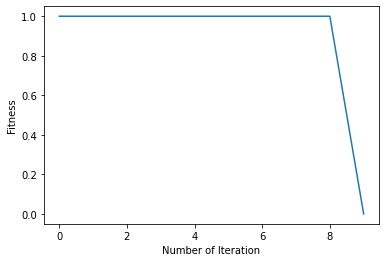

Total elapsed time:  172.10585069656372


In [84]:
#///////////////////////lab 4.2///////////////////////
#Main function - Please Run all prerequired first to create the files

import time
import sys
import math
import numpy as np
from timeit import default_timer as timer
from random import randint, random, randrange
from numpy.random import choice, uniform
from matplotlib import pyplot as plt
import Dummy
import Iocaine
import Greenbrerg


CRED = '\033[91m'
CGREEN = '\033[92m'
CFLASH = '\033[5m'
CBOLD = '\33[1m'
CITALIC = '\33[3m'
CEND = '\033[0m'

GA_ELITRATE = 0.1 # elitism rate
GA_MAXITER = 100 # maximum iterations
GA_POPSIZE = 200 # ga population size
GA_TARGET = "Hello World!"
GA_MUTATIONRATE = 0.1 #  mutation rate
GA_MAXMUTATIONRATE = 0.75 # max mutation rate
GA_MINMUTATIONRATE = 0.1 #  min mutation rate
GA_MUTATION = sys.maxsize * GA_MUTATIONRATE
t=0 #genration number
rate=0.5
IMMIGRANTSNUM = 25 # number of individuals to replace - Random Immigrants


class Agent:   
    def __init__(self, array, fitness):
        self.array = array
        self.fitness = fitness
        self.age = 0

class GA5:
  def __init__(self,GA_POPSIZE,GA_ELITRATE,GA_MAXITER,GA_MUTATIONRATE):
        self.esize = int(GA_POPSIZE * GA_ELITRATE)
        self.population = []
        self.parasites = []
        self.buffer = []
        self.best = []

  def initPop(self):  
  #initialize population

      for i in range(GA_POPSIZE):
          array = [randint(0, 2) for i in range(1000)]
          player = Agent(array, 0)
          self.population.append(player)

      self.parasites.append(Dummy.AntiFlat())
      self.parasites.append(Dummy.Bruijn81())
      self.parasites.append(Dummy.Copy())
      self.parasites.append(Dummy.Flat())
      self.parasites.append(Dummy.Foxtrot())
      self.parasites.append(Dummy.Freq())
      self.parasites.append(Dummy.Pi())
      self.parasites.append(Dummy.Play226())
      self.parasites.append(Dummy.RndPlayer())
      self.parasites.append(Dummy.Rotate())
      self.parasites.append(Dummy.Switch())
      self.parasites.append(Dummy.SwitchALot())
      #self.parasites.append(Iocaine.iocaine_agent())
      #self.parasites.append(Greenbrerg.player())

  def calcFitness(self, population: list):
      win = 0
      round = 0
      for i in self.population:
          for j in self.parasites:
              j.newGame(len(i.array))
              for k in range(len(i.array)):
                  m = self.result(i.array[k], j.nextMove())
                  round = round + m
                  j.storeMove(i.array[k], m)
              if round > 0:
                  win = win + 1
              round = 0
          i.fitness = win
          win = 0

  def match(self):
      round = 0
      avg = 0
      score = 0
      total = 0
      lst = []
      for bot in self.parasites:
          for i in range(10):
              bot.newGame(1000)
              for j in range(1000):
                  r = self.result(self.best[j], bot.nextMove())
                  round += r
                  bot.storeMove(self.best[j], r)

              lst.append(round)
              avg += round
              round = 0
          avg /= 10
          for i in range(10):
              total += abs(lst[i] - avg) ** 2
          score = total / 10
          result = math.sqrt(score)
          print(CEND + "average against " + CBOLD, bot.getName(), CEND + " is: " + CGREEN, avg)
          print(CEND + "score against " + CBOLD, bot.getName(), CEND + "is: " + CGREEN, result)

  def tournament(self):
      round = 0
      results = {"Anti Flat Player": 0, "Bruijn 81 Player": 0, "Copy Player": 0, "Flat Player": 0
          , "Foxtrot Player": 0, "Freq Player": 0, "Pi Player": 0, "226 Player": 0
          , "Random Player": 0, "Rotating Player": 0, "Switching Player": 0, "Switch a Lot Player": 0, "New Player": 0}
      for par in self.parasites:
          for par2 in self.parasites:
              if par != par2:
                  par.newGame(1000)
                  par2.newGame(1000)
                  for i in range(1000):
                      a = par.nextMove()
                      b = par2.nextMove()
                      r = self.result(a, b)
                      round += r
                      par2.storeMove(a, r)
                      par2.storeMove(b, -r)
                  results[par.getName()] += round
                  results[par2.getName()] -= round

      for i in range(2):
          for par2 in self.parasites:
              par2.newGame(1000)
              for i in range(1000):
                  r = self.result(self.best[i], par2.nextMove())
                  round += r
                  par2.storeMove(self.best[i], r)
              results["New Player"] += round
              results[par2.getName()] -= round
      
      board = sorted(results.items(), key=lambda x: x[1], reverse = True)          
      print("Leading Board")
      print("-------------------------")
      for i in range(len(board)):
          print (board[i])



  def result(self, player1, player2):
      if (player1 == player2):
          return 0
      elif (player2 == 0):
          if (player1 == 1):
              return 1
      elif (player2 == 1):
          if (player1 == 2):
              return 1
      elif (player2 == 2):
          if (player1 == 0):
              return 1
      return -1

  def sort_by_fitness(self, population: list):
      population.sort(key=lambda i: i.fitness)

  def mate(self):
      self.elitism(self.population, self.buffer)
      for i in range(self.esize, GA_POPSIZE):
          i1 = i
          while i1 == i:
              i1 = randint(0, (GA_POPSIZE) - 1)
          bf1 = randint(1, 2)
          bf2 = randint(1, 2)
          mv = [num1 + num2 for num1, num2 in zip(self.population[i].array, self.population[i1].array)]
          res = [int(num1 / 2) for num1 in mv]
          mv = res
          mv2 = mv
          res = [num * bf1 for num in mv]
          res2 = [abs(num1 - num2) for num1, num2 in zip(self.best, res)]
          res3 = [int(num * uniform(0, 1)) for num in res2]
          gene = [num + num2 for num, num2 in zip(self.population[i].array, res3)]
          mv = mv2
          res = [num * bf2 for num in mv]
          res2 = [abs(num1 - num2) for num1, num2 in zip(self.best, res)]
          res3 = [int(num * uniform(0, 1)) for num in res2]
          gene2 = [num + num2 for num, num2 in zip(self.population[i1].array, res3)]


          win = 0
          rounds = 0
          for par in self.parasites:
              par.newGame(len(gene))
              for k in range(len(gene)):
                  r = self.result(gene[k], par.nextMove())
                  rounds += r
                  par.storeMove(gene[k], r)
              if rounds > 0:
                  win += 1
              rounds = 0

          if (win > self.population[i].fitness):
              self.population[i] = Agent(gene, win)
          win = 0
          rounds = 0
          for par in self.parasites:
              par.newGame(len(gene2))
              for k in range(len(gene2)):
                  r = self.result(gene2[k], par.nextMove())
                  rounds += r
                  par.storeMove(gene2[k], r)
              if rounds > 0:
                  win += 1
              rounds = 0

          if (win > self.population[i1].fitness):
              self.population[i1] = Agent(gene2, win)
      self.commensalism()
    
  def elitism(self, population: list, buffer: list):
      flag = 0
      temp = []
      while len(temp) < self.esize:
          temp.append(population[flag])
          flag += 1
      self.population[:self.esize] = temp
      for i in range(self.esize):
          self.population[i].age += 1

  def commensalism(self):
      for i in range(self.esize, GA_POPSIZE):
          i1 = i
          while i1 == i:
              i1 = randint(0, (GA_POPSIZE) - 1)

          res2 = [abs(num1 - num2) for num1, num2 in zip(self.best, self.population[i].array)]
          res3 = [num * choice([-1, 1]) for num in res2]
          gene = [num + num2 for num, num2 in zip(self.population[i].array, res3)]

          win = 0
          rounds = 0

          for par in self.parasites:
              par.newGame(len(gene))
              for k in range(len(gene)):
                  r = self.result(gene[k], par.nextMove())
                  rounds += r
                  par.storeMove(gene[k], r)
              if rounds > 0:
                  win += 1
              rounds = 0

          if (win > self.population[i].fitness):
              self.population[i] = Agent(gene, win)

      self.paraisitsm()

  def paraisitsm(self):
      for i in range(self.esize, GA_POPSIZE):
          i1 = i
          while i1 == i:
              i1 = randint(0, (GA_POPSIZE) - 1)
          pv = self.population[i].array
          for j in range(len(self.population[i].array)):
              if uniform(0, 1) < GA_MUTATION:
                  pv[j] = randint(0, 2)
          win = 0
          rounds = 0

          for par in self.parasites:
              par.newGame(len(pv))
              for k in range(len(pv)):
                  r = self.result(pv[k], par.nextMove())
                  rounds += r
                  par.storeMove(pv[k], r)

              if rounds > 0:
                  win += 1

              rounds = 0

          if (win > self.population[i].fitness):
              self.population[i] = Agent(pv, win)

starting_time = time.time()  # the start time of clock ticks
start_elapsed = timer()  # the start time of elapsed
ga = GA5(GA_POPSIZE,GA_ELITRATE,GA_MAXITER,GA_MUTATIONRATE)
esize = int(GA_POPSIZE * GA_ELITRATE)
ga.initPop()
graph = []


ga.calcFitness(ga.population)
ga.sort_by_fitness(ga.population)
best_fitness=ga.population[0].fitness
ga.best = ga.population[0].array
for i in range(GA_MAXITER):
    iteration_time = time.time()
    ga.calcFitness(ga.population)
    ga.sort_by_fitness(ga.population)
    if ga.population[0].fitness < best_fitness:
        ga.best=ga.population[0].array
        best_fitness=ga.population[0].fitness
    print(CEND + "Fitness: " + CGREEN, best_fitness)
    print(CEND + "Best Player: " + CGREEN,ga.best)

    graph.append(best_fitness)
    if ga.population[0].fitness == 0:
        print()
        print(CEND + "Best string: " + CGREEN, ga.population[0].array)
        print(f'found in {i} iterations out of {GA_MAXITER}')
        elapsed_time = timer() - start_elapsed
        print(CEND + "Elapsed Time: " + CGREEN, elapsed_time)
        break
    ga.mate()
    clock_ticks = time.time() - iteration_time
    print(CEND + "Clock Ticks Time: " + CGREEN, clock_ticks)
ga.match()
ga.tournament()
fig, ax = plt.subplots()
gennumarr = []
for i in range(len(graph)):
    gennumarr.append(i)
ax.plot(gennumarr, graph)
plt.xlabel('Number of Iteration')
plt.ylabel('Fitness')
plt.show()


print(CEND + "Total elapsed time: " + CRED,str(time.time() - starting_time))